In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM


In [30]:
daily = pd.read_csv("../data/raw/features_daily.csv", index_col=0, parse_dates=True)
weekly = pd.read_csv("../data/raw/features_weekly.csv", index_col=0, parse_dates=True)


In [31]:
hmm_weekly = GaussianHMM(
    n_components=4,
    covariance_type="full",
    n_iter=500,
    random_state=42
)

hmm_weekly.fit(weekly.values)
weekly["hmm_state"] = hmm_weekly.predict(weekly.values)


In [32]:
hmm_daily = GaussianHMM(
    n_components=4,
    covariance_type="full",
    n_iter=500,
    random_state=42
)

hmm_daily.fit(daily.values)
daily["hmm_state"] = hmm_daily.predict(daily.values)


In [33]:
prices_weekly = pd.read_csv(
    "../data/raw/sp500_weekly.csv",
    index_col=0,
    parse_dates=True
)

prices_daily = pd.read_csv(
    "../data/raw/sp500_daily.csv",
    index_col=0,
    parse_dates=True
)


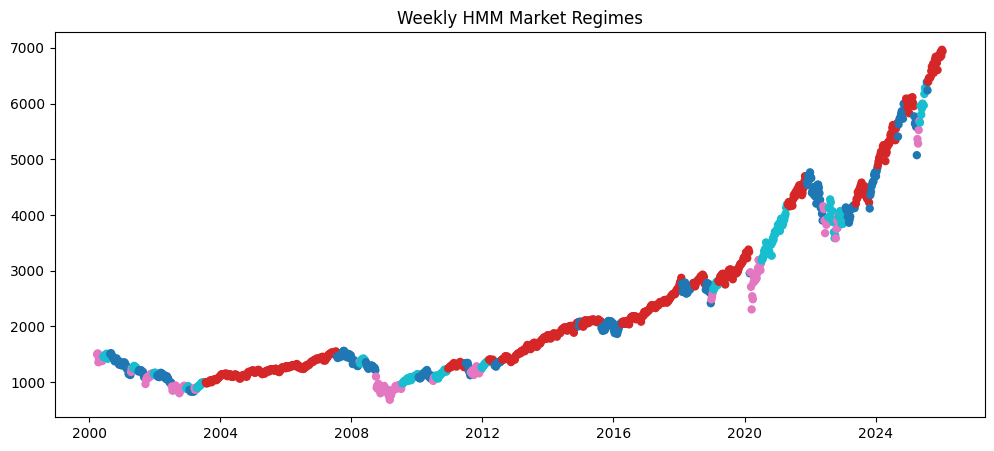

In [34]:
plt.figure(figsize=(12,5))
plt.scatter(
    prices_weekly.loc[weekly.index].index,
    prices_weekly.loc[weekly.index]["SP500_Close"],
    c=weekly["hmm_state"],
    cmap="tab10",
    s=25
)
plt.title("Weekly HMM Market Regimes")
plt.show()


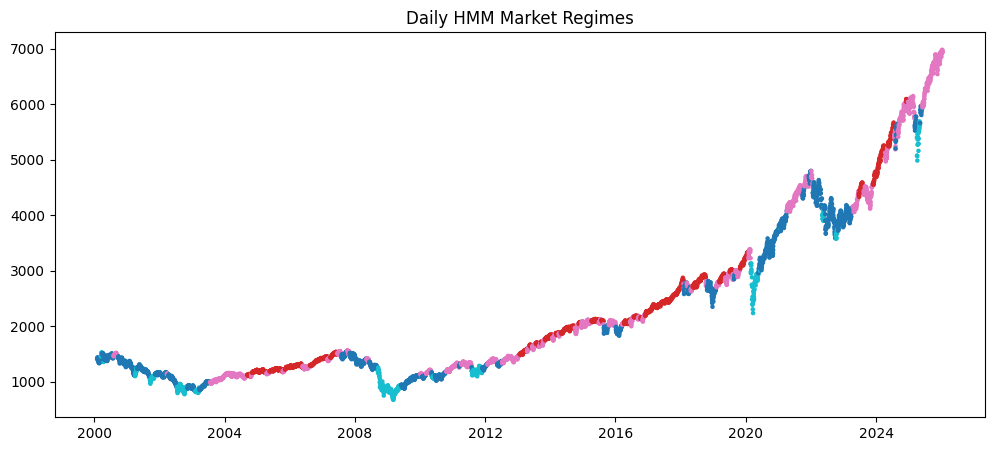

In [35]:
plt.figure(figsize=(12,5))
plt.scatter(
    prices_daily.loc[daily.index].index,
    prices_daily.loc[daily.index]["SP500_Close"],
    c=daily["hmm_state"],
    cmap="tab10",
    s=5
)
plt.title("Daily HMM Market Regimes")
plt.show()


In [36]:
weekly_trans = hmm_weekly.transmat_
weekly_trans


array([[9.32761081e-001, 2.73202511e-002, 3.99184601e-002,
        2.07852124e-007],
       [1.79978866e-002, 9.82002113e-001, 3.01874110e-321,
        2.16517254e-121],
       [2.35581714e-071, 6.43176883e-255, 9.11744599e-001,
        8.82554014e-002],
       [4.36748146e-002, 2.48359340e-002, 3.51847854e-003,
        9.27970773e-001]])

In [37]:
daily_trans = hmm_daily.transmat_
daily_trans


array([[9.80580716e-001, 4.65553700e-149, 1.14091924e-002,
        8.01009110e-003],
       [9.64864304e-170, 9.83359926e-001, 1.66400742e-002,
        5.52362290e-184],
       [1.03383217e-002, 1.36131960e-002, 9.76016552e-001,
        3.19305231e-005],
       [2.80573698e-002, 5.99806117e-209, 1.72737778e-112,
        9.71942630e-001]])

In [38]:
def avg_duration(states):
    durations = []
    current = states.iloc[0]
    length = 1
    
    for s in states.iloc[1:]:
        if s == current:
            length += 1
        else:
            durations.append(length)
            current = s
            length = 1
            
    durations.append(length)
    return np.mean(durations)


In [39]:
print("Avg weekly regime duration:", avg_duration(weekly["hmm_state"]))
print("Avg daily regime duration:", avg_duration(daily["hmm_state"]))


Avg weekly regime duration: 22.081967213114755
Avg daily regime duration: 48.723880597014926


In [40]:
weekly.groupby("hmm_state").mean()


,sp500_ret,sp500_vol,trend,vix_ret,vix_level
hmm_state,,,,,
0,-0.235516,0.120442,-0.514647,0.136962,0.138321
1,0.058605,-0.645782,0.304816,0.007620,-0.679884
2,0.020461,1.982914,-1.102151,-0.188131,1.917869
3,0.154204,0.493805,0.627089,-0.095836,0.635788


In [41]:
regime_summary = (
    weekly
    .groupby("hmm_state")
    .agg(
        avg_return=("sp500_ret", "mean"),
        avg_volatility=("sp500_vol", "mean"),
        avg_trend=("trend", "mean"),
        avg_vix_level=("vix_level", "mean"),
        obs_count=("sp500_ret", "count")
    )
)

regime_summary

,avg_return,avg_volatility,avg_trend,avg_vix_level,obs_count
hmm_state,,,,,
0,-0.235516,0.120442,-0.514647,0.138321,312
1,0.058605,-0.645782,0.304816,-0.679884,684
2,0.020461,1.982914,-1.102151,1.917869,155
3,0.154204,0.493805,0.627089,0.635788,196


In [42]:
regime_labels = {
    0: "Bull / Expansion",
    1: "Bear / Crisis",
    2: "Sideways / Low Vol",
    3: "Volatile / Transition"
}

weekly["regime_label"] = weekly["hmm_state"].map(regime_labels)


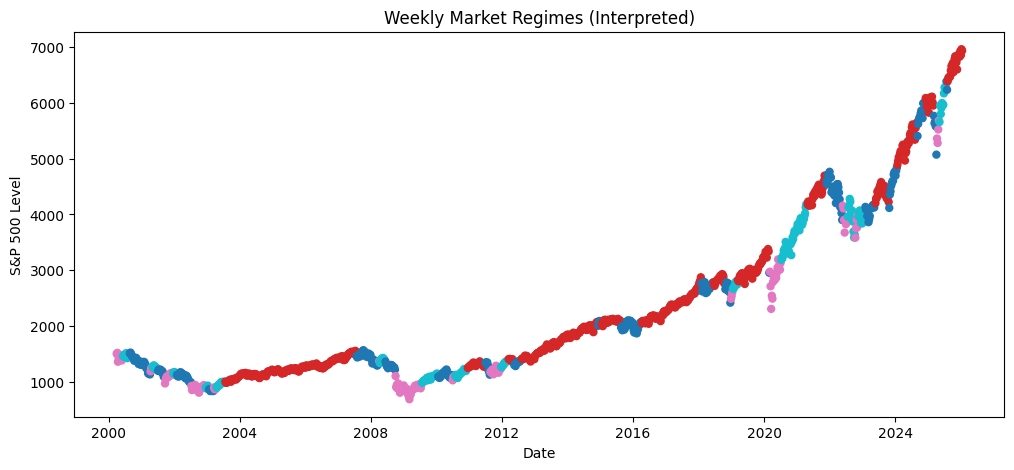

In [43]:
prices_weekly = pd.read_csv(
    "../data/raw/sp500_weekly.csv",
    index_col=0,
    parse_dates=True
)
weekly_plot = weekly.join(
    prices_weekly["SP500_Close"],
    how="inner"
)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(
    weekly_plot.index,
    weekly_plot["SP500_Close"],
    c=weekly_plot["hmm_state"],
    cmap="tab10",
    s=25
)
plt.title("Weekly Market Regimes (Interpreted)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Level")
plt.show()


In [44]:
weekly_plot.groupby("regime_label")["SP500_Close"].describe()


,count,mean,std,min,25%,50%,75%,max
regime_label,,,,,,,,
Bear / Crisis,684.0,2403.591404,1488.512357,977.590027,1303.947510,1914.849976,2871.977478,6966.279785
Bull / Expansion,312.0,2316.990995,1481.339870,828.890015,1250.239960,1480.255005,2779.525024,6388.640137
Sideways / Low Vol,155.0,1616.486131,1150.132802,683.380005,890.079987,1099.229980,1507.464966,5686.669922
Volatile / Transition,196.0,2363.258569,1504.611560,875.400024,1124.602478,1399.109985,3704.647522,6296.790039


In [45]:
weekly.loc["2008":"2009", ["regime_label"]].value_counts()


regime_label         
Sideways / Low Vol       43
Volatile / Transition    32
Bull / Expansion         29
Name: count, dtype: int64

In [46]:
weekly.to_csv("../data/raw/weekly_regimes_labeled.csv")
